<a href="https://colab.research.google.com/github/Pengyu-gis/Historical-Aerial-Photos/blob/main/docs/examples/sam2_automatic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automatic Mask Generation with SAM 2

[![image](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/opengeos/segment-geospatial/blob/main/docs/examples/sam2_automatic.ipynb)
[![image](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/opengeos/segment-geospatial/blob/main/docs/examples/sam2_automatic.ipynb)

This notebook shows how to segment objects from an image using the Segment Anything Model 2 (SAM2) with a few lines of code.

Make sure you use GPU runtime for this notebook. For Google Colab, go to `Runtime` -> `Change runtime type` and select `GPU` as the hardware accelerator.

## Install dependencies

Uncomment and run the following cell to install the required dependencies.

In [1]:
%pip install -U segment-geospatial

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.3/75.3 kB 5.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 10.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 102.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.9/96.9 kB 9.2 MB/s eta 0:00:

In [1]:
import leafmap
from samgeo import SamGeo2

## Create an interactive map

In [2]:
m = leafmap.Map(center=[29.6768, -95.3692], zoom=19)
m.add_basemap("SATELLITE")
m

Map(center=[29.6768, -95.3692], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…


Pan and zoom the map to select the area of interest. Use the draw tools to draw a polygon or rectangle on the map

In [3]:
if m.user_roi_bounds() is not None:
    bbox = m.user_roi_bounds()
else:
    bbox = [-95.3704, 29.6762, -95.368, 29.6775]

## Download a sample image

In [ ]:
image = "satellite.tif"
leafmap.map_tiles_to_geotiff(
    output=image, bbox=bbox, zoom=20, source="Satellite", overwrite=True
)

You can also use your own image. Uncomment and run the following cell to use your own image.

In [23]:
image = '/content/Clip1_0087_x_24_Clip_small1.tif'

Display the downloaded image on the map.

In [24]:
m.layers[-1].visible = False
m.add_raster(image, layer_name="Image")
m

Map(bottom=3384732.0, center=[32.797741, -80.004346], controls=(ZoomControl(options=['position', 'zoom_in_text…

## Initialize SAM class

In [25]:
sam2 = SamGeo2(model_id="sam2-hiera-large", automatic=True)

## Automatic mask generation

Segment the image and save the results to a GeoTIFF file. Set `unique=True` to assign a unique ID to each object.

In [26]:
sam2.generate(image)

In [27]:
sam2.save_masks(output="masks.tif")

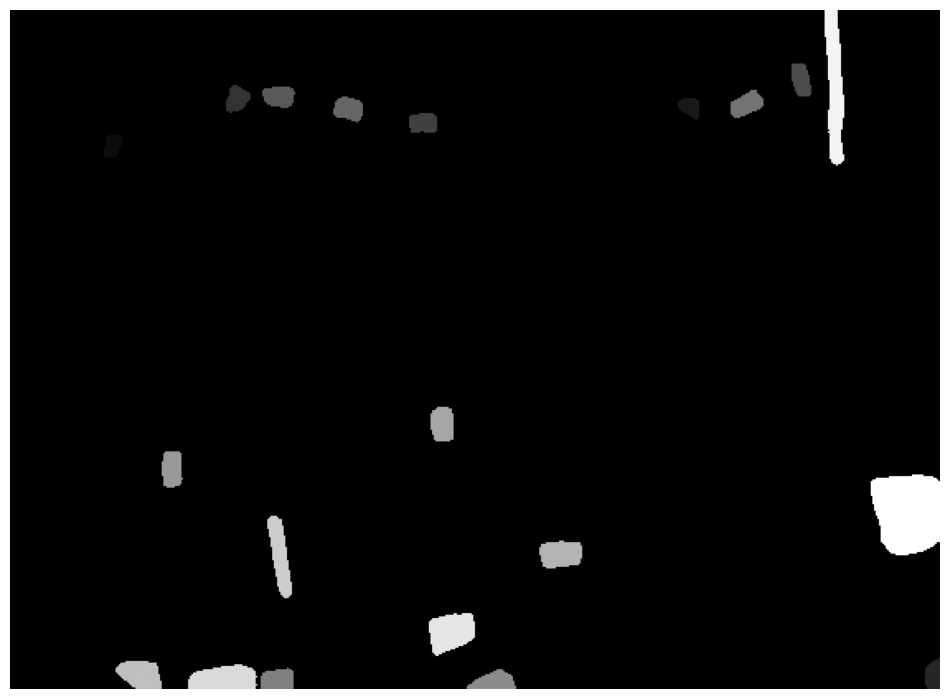

In [28]:
sam2.show_masks(cmap="binary_r")

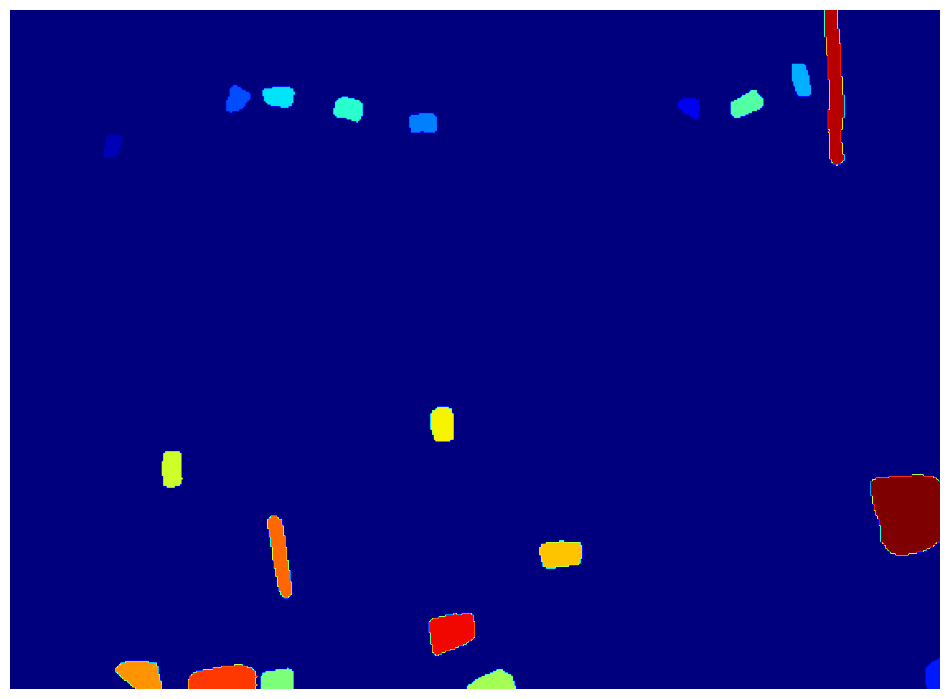

In [29]:
sam2.show_masks(cmap="jet")

Show the object annotations (objects with random color) on the map.

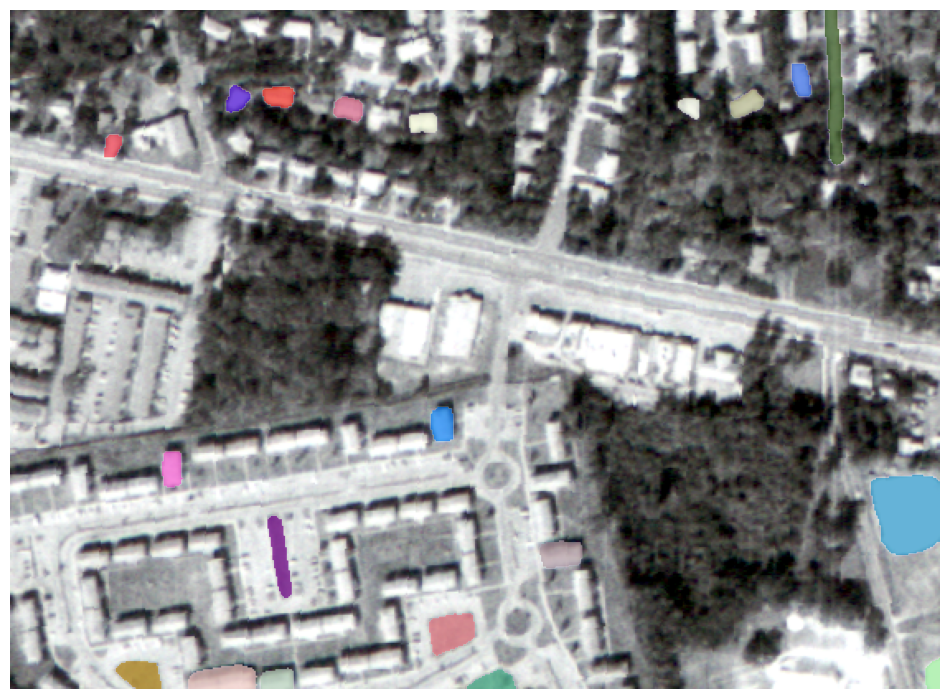

In [30]:
sam2.show_anns(axis="off", alpha=0.7, output="annotations.tif")

Compare images with a slider.


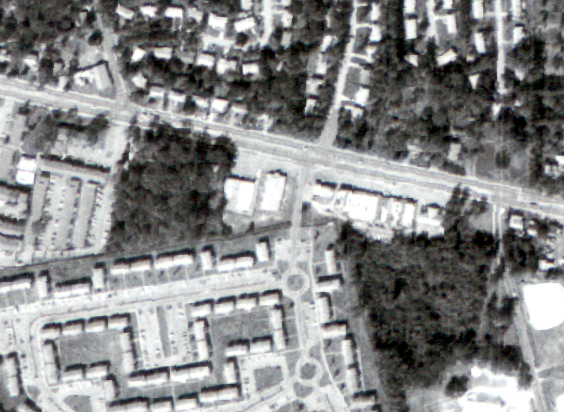
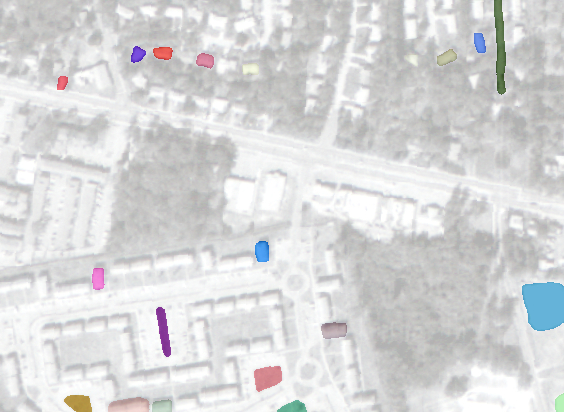

In [31]:
leafmap.image_comparison(
    "/content/Clip1_0087_x_24_Clip_small1.tif",
    "annotations.tif",
    label1="Satellite Image",
    label2="Image Segmentation",
)

Add image to the map.

In [13]:
m.add_raster("masks.tif", colormap="jet", layer_name="Masks", nodata=0, opacity=0.7)
m

Map(bottom=1692588.0, center=[32.796523, -80.00122], controls=(ZoomControl(options=['position', 'zoom_in_text'…

Convert the object annotations to vector format, such as GeoPackage, Shapefile, or GeoJSON.

In [14]:
sam2.raster_to_vector("masks.tif", "masks.gpkg")

In [15]:
m.add_vector("masks.gpkg", layer_name="Objects")

## Automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:

In [32]:
sam2 = SamGeo2(
    model_id="sam2-hiera-large",
    apply_postprocessing=False,
    points_per_side=32,
    points_per_batch=64,
    pred_iou_thresh=0.7,
    stability_score_thresh=0.92,
    stability_score_offset=0.7,
    crop_n_layers=1,
    box_nms_thresh=0.7,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=25.0,
    use_m2m=True,
)

In [33]:
sam2.generate(image, output="masks2.tif")

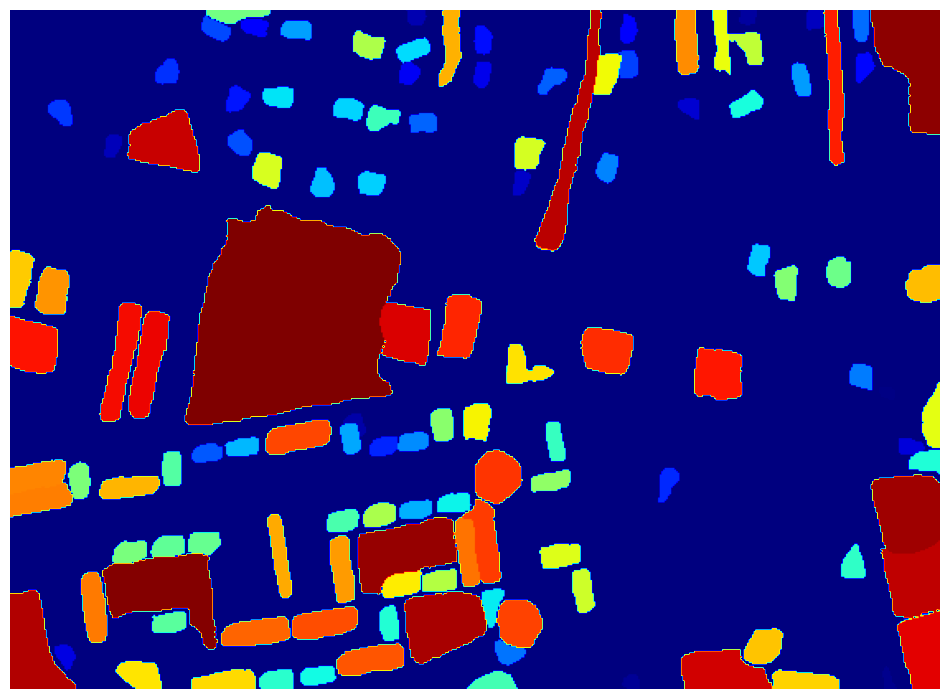

In [34]:
sam2.show_masks(cmap="jet")

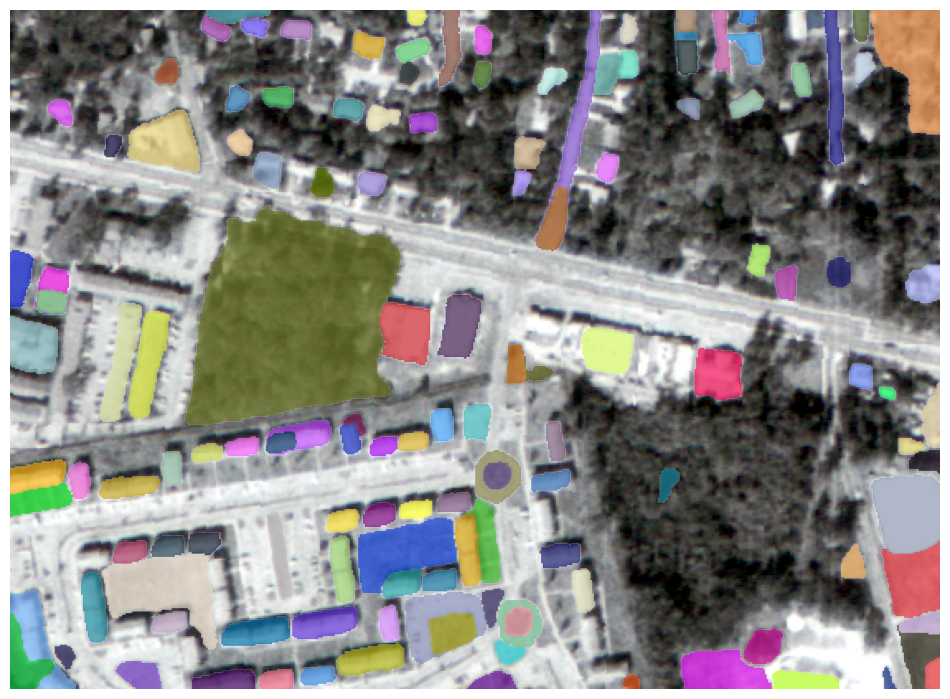

In [35]:
sam2.show_anns(axis="off", alpha=0.7, output="annotations2.tif")

Compare images with a slider.


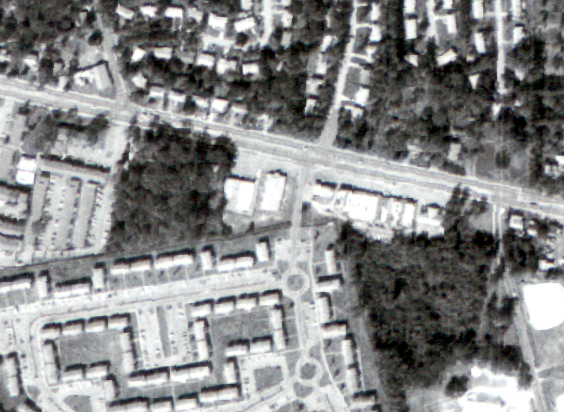
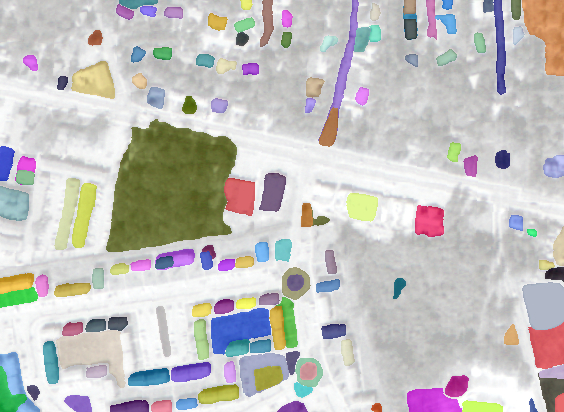

In [36]:
leafmap.image_comparison(
    image,
    "annotations2.tif",
    label1="Image",
    label2="Image Segmentation",
)